In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install grad-cam

In [ ]:
!pip install ultralytics -q

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import time
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam import ScoreCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import tqdm
import torch.nn.functional as F
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
# GPU 사용 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
class DenseNetWithRelu0(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()
        base = models.densenet121(pretrained=True)
        self.features = base.features
        self.classifier = nn.Linear(1024, num_classes)

        # relu0까지 명시적으로 접근 가능하도록
        self.conv0 = self.features.conv0
        self.norm0 = self.features.norm0
        self.relu0 = self.features.relu0
        self.pool0 = self.features.pool0
        self.dense1 = self.features.denseblock1
        self.trans1 = self.features.transition1
        self.dense2 = self.features.denseblock2
        self.trans2 = self.features.transition2
        self.dense3 = self.features.denseblock3
        self.trans3 = self.features.transition3
        self.dense4 = self.features.denseblock4
        self.norm5 = self.features.norm5

    def forward(self, x):
        x = self.conv0(x)
        x = self.norm0(x)
        x = self.relu0(x)
        self.feature_map_relu0 = x  #저장

        x = self.pool0(x)
        x = self.dense1(x)
        x = self.trans1(x)
        x = self.dense2(x)
        x = self.trans2(x)
        x = self.dense3(x)
        x = self.trans3(x)
        x = self.dense4(x)
        x = self.norm5(x)

        out = F.adaptive_avg_pool2d(x, (1, 1)).view(x.size(0), -1)
        return self.classifier(out)

In [7]:
dens_model = DenseNetWithRelu0(num_classes=7).to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 151MB/s]


In [ ]:
#pth파일경로 수정 필요
dens_model.load_state_dict(torch.load('/content/featuremap_train_densenet121.pth', map_location=device))
dens_model.to(device)
dens_model.eval()

In [9]:
target_layer = dens_model.features.relu0

In [ ]:
#pt파일경로 수정 필요
seg_model = YOLO('/content/yolov8_best.pt')  # 또는 yolov8m-seg.pt, yolov8n-seg.pt 등
seg_model.eval()

In [11]:
#csv파일경로 수정 필요
import pandas as pd
df_density = pd.read_csv('/content/hair_density_filtered_and_scored_percent.csv')

In [12]:
mean = [0.43755555152893066, 0.39420410990715027, 0.3537991940975189]
std = [0.21359124779701233, 0.19734203815460205, 0.18219676613807678]

In [13]:
# 원본, 마스크, 캠
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
from pytorch_grad_cam import ScoreCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from scipy.ndimage import gaussian_filter

def generate_elliptical_roi(shape=(224, 224), x_ratio=0.5, y_ratio=0.35):
    h, w = shape
    Y, X = np.ogrid[:h, :w]
    cy, cx = h // 2, w // 2
    rx = int(w * x_ratio)
    ry = int(h * y_ratio)
    mask = ((X - cx)**2 / rx**2 + (Y - cy)**2 / ry**2) <= 1
    return mask.astype(np.float32)

def predict_and_visualize_all(
    image_path, class_model, seg_model,
    target_layer, df_density,
    mask_dir=None, device='cuda', cam_alpha=0.6, cam_thresh=0.6
):
    class_model.to(device).eval()
    seg_model.to(device).eval()

    image = Image.open(image_path).convert('RGB')
    image_resized = image.resize((224, 224))
    img_np = np.array(image_resized)
    img_np_original = np.array(image)

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    image_tensor = transform(image).unsqueeze(0).to(device)

    results = seg_model.predict(source=image_path, save=False, imgsz=640, conf=0.25)
    result = results[0]

    mask_h, mask_w = result.orig_shape
    color_mask = np.zeros((mask_h, mask_w, 3), dtype=np.uint8)
    roi_mask = np.zeros((mask_h, mask_w), dtype=np.uint8)

    if result.masks is not None:
        masks = result.masks.data.cpu().numpy()
        classes = result.boxes.cls.cpu().numpy().astype(int)
        for i, class_id in enumerate(classes):
            mask = masks[i]
            binary_mask = (mask > 0.5).astype(np.uint8)
            color = (0, 255, 0) if class_id == 1 else (0, 0, 255)
            for c in range(3):
                color_mask[..., c][binary_mask == 1] = color[c]
            roi_mask[binary_mask == 1] = 1

    with torch.no_grad():
        logits = class_model(image_tensor)
        pred_class = torch.argmax(logits, dim=1).item()

    cam_extractor = ScoreCAM(model=class_model, target_layers=[target_layer])
    grayscale_cam = cam_extractor(input_tensor=image_tensor, targets=[ClassifierOutputTarget(pred_class)])[0]

    grayscale_cam -= grayscale_cam.min()
    grayscale_cam /= grayscale_cam.max() + 1e-6
    grayscale_cam = np.clip(grayscale_cam, 0.1, 1.0)     # 구멍 방지
    grayscale_cam = gaussian_filter(grayscale_cam, sigma=3)     # 블러 완화

    # Threshold + closing
    cam_mask = (grayscale_cam >= cam_thresh).astype(np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (21, 21))
    cam_mask_closed = cv2.morphologyEx(cam_mask, cv2.MORPH_CLOSE, kernel)

    # ROI 마스크 → closing 적용
    roi_resized = cv2.resize(roi_mask.astype(np.uint8), (224, 224), interpolation=cv2.INTER_NEAREST)
    roi_closed = cv2.morphologyEx(roi_resized, cv2.MORPH_CLOSE, kernel)

    # 두 마스크 모두 CAM에 곱하기
    grayscale_cam *= roi_closed.astype(np.float32)
    grayscale_cam *= cam_mask_closed.astype(np.float32)

    # 부드러운 마무리 closing
    kernel_smooth = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13, 13))
    grayscale_cam = cv2.morphologyEx(grayscale_cam.astype(np.float32), cv2.MORPH_CLOSE, kernel_smooth)

    # 경계 부드럽게 만들기 추가
    grayscale_cam = cv2.GaussianBlur(grayscale_cam, (15, 15), sigmaX=3)

    # thresholding
    grayscale_cam = np.where(grayscale_cam >= 0.5, grayscale_cam, 0)

    img_np_norm = img_np.astype(np.float32) / 255.0
    cam_overlay = show_cam_on_image(img_np_norm, grayscale_cam, use_rgb=True, image_weight=1 - cam_alpha)

    # --- 4. Density score 계산 (% 기반, clipping 없이) ---
    hair_mask = np.all(color_mask == [0, 255, 0], axis=-1)
    roi_mask_bool = (color_mask != [0, 0, 0]).any(axis=-1)
    hair_percent = (hair_mask.sum() / (roi_mask_bool.sum() + 1e-6)) * 100  # ← % 기반

    row = df_density[df_density['class'] == (pred_class + 1)].iloc[0]
    class_avg = row['avg_hair_ratio']

    class1_avg = df_density[df_density['class'] == 1]['avg_hair_ratio'].values[0]
    class7_avg = df_density[df_density['class'] == 7]['avg_hair_ratio'].values[0]
    abs_score = ((hair_percent - class7_avg) / (class1_avg - class7_avg)) * 100  # ← clipping 제거, epsilon 제거

    cam_overlay_resized = cv2.resize(cam_overlay, (mask_w, mask_h), interpolation=cv2.INTER_LINEAR)

    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_np_original)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cam_overlay_resized)
    plt.title(f"CAM Overlay\nClass {pred_class+1} | Hair %: {hair_percent:.2f} | Score: {abs_score:.1f}\n"
              f"→ Class {pred_class+1} Avg: {class_avg:.2f}%")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return {
        'pred_class': pred_class + 1,
        'hair_percent': hair_percent,
        'abs_score': abs_score,
        'class_avg': class_avg
    }


In [15]:
def predict_and_visualize_all(
    image_path, class_model, seg_model,
    target_layer, df_density,
    mask_dir=None, device='cuda', cam_alpha=0.6, cam_thresh=0.6
):
    class_model.to(device).eval()
    seg_model.to(device).eval()

    image = Image.open(image_path).convert('RGB')
    image_resized = image.resize((224, 224))
    img_np = np.array(image_resized)
    img_np_original = np.array(image)

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    image_tensor = transform(image).unsqueeze(0).to(device)

    results = seg_model.predict(source=image_path, save=False, imgsz=640, conf=0.25)
    result = results[0]

    mask_h, mask_w = result.orig_shape
    color_mask = np.zeros((mask_h, mask_w, 3), dtype=np.uint8)
    roi_mask = np.zeros((mask_h, mask_w), dtype=np.uint8)

    if result.masks is not None:
        masks = result.masks.data.cpu().numpy()
        classes = result.boxes.cls.cpu().numpy().astype(int)
        for i, class_id in enumerate(classes):
            mask = masks[i]
            binary_mask = (mask > 0.5).astype(np.uint8)
            color = (0, 255, 0) if class_id == 1 else (0, 0, 255)
            for c in range(3):
                color_mask[..., c][binary_mask == 1] = color[c]
            roi_mask[binary_mask == 1] = 1

    with torch.no_grad():
        logits = class_model(image_tensor)
        pred_class = torch.argmax(logits, dim=1).item()

    cam_extractor = ScoreCAM(model=class_model, target_layers=[target_layer])
    grayscale_cam = cam_extractor(input_tensor=image_tensor, targets=[ClassifierOutputTarget(pred_class)])[0]

    grayscale_cam -= grayscale_cam.min()
    grayscale_cam /= grayscale_cam.max() + 1e-6
    grayscale_cam = np.clip(grayscale_cam, 0.1, 1.0)
    grayscale_cam = gaussian_filter(grayscale_cam, sigma=3)

    cam_mask = (grayscale_cam >= cam_thresh).astype(np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (21, 21))
    cam_mask_closed = cv2.morphologyEx(cam_mask, cv2.MORPH_CLOSE, kernel)

    roi_resized = cv2.resize(roi_mask.astype(np.uint8), (224, 224), interpolation=cv2.INTER_NEAREST)
    roi_closed = cv2.morphologyEx(roi_resized, cv2.MORPH_CLOSE, kernel)

    grayscale_cam *= roi_closed.astype(np.float32)
    grayscale_cam *= cam_mask_closed.astype(np.float32)

    kernel_smooth = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13, 13))
    grayscale_cam = cv2.morphologyEx(grayscale_cam.astype(np.float32), cv2.MORPH_CLOSE, kernel_smooth)
    grayscale_cam = cv2.GaussianBlur(grayscale_cam, (15, 15), sigmaX=3)
    grayscale_cam = np.where(grayscale_cam >= 0.5, grayscale_cam, 0)

    img_np_norm = img_np.astype(np.float32) / 255.0
    cam_overlay = show_cam_on_image(img_np_norm, grayscale_cam, use_rgb=True, image_weight=1 - cam_alpha)

    # --- 4. Density score 계산 ---
    hair_mask = np.all(color_mask == [0, 255, 0], axis=-1)
    roi_mask_bool = (color_mask != [0, 0, 0]).any(axis=-1)
    hair_percent = (hair_mask.sum() / (roi_mask_bool.sum() + 1e-6)) * 100

    class1_avg = df_density[df_density['class'] == 1]['avg_hair_ratio'].values[0]
    class7_avg = df_density[df_density['class'] == 7]['avg_hair_ratio'].values[0]

    abs_score = ((hair_percent - class7_avg) / (class1_avg - class7_avg)) * 100

    # 🔄 class 평균도 동일 기준선으로 선형보간
    row = df_density[df_density['class'] == (pred_class + 1)].iloc[0]
    class_avg = row['avg_hair_ratio']
    class_avg_score = ((class_avg - class7_avg) / (class1_avg - class7_avg)) * 100

    cam_overlay_resized = cv2.resize(cam_overlay, (mask_w, mask_h), interpolation=cv2.INTER_LINEAR)

    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_np_original)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cam_overlay_resized)
    plt.title(f"CAM Overlay\nClass {pred_class+1} | Hair %: {hair_percent:.2f} | Score: {abs_score:.1f}\n"
              f"→ Class {pred_class+1} Avg Score: {class_avg_score:.1f}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return {
        'pred_class': pred_class + 1,
        'hair_percent': hair_percent,
        'abs_score': abs_score,
        'class_avg_score': class_avg_score
    }


image 1/1 /content/drive/MyDrive/Colab Notebooks/hair_classification/data/test/109.jpg: 640x640 2 balds, 1 hair, 45.6ms
Speed: 1.9ms preprocess, 45.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


100%|██████████| 4/4 [00:00<00:00, 11.03it/s]


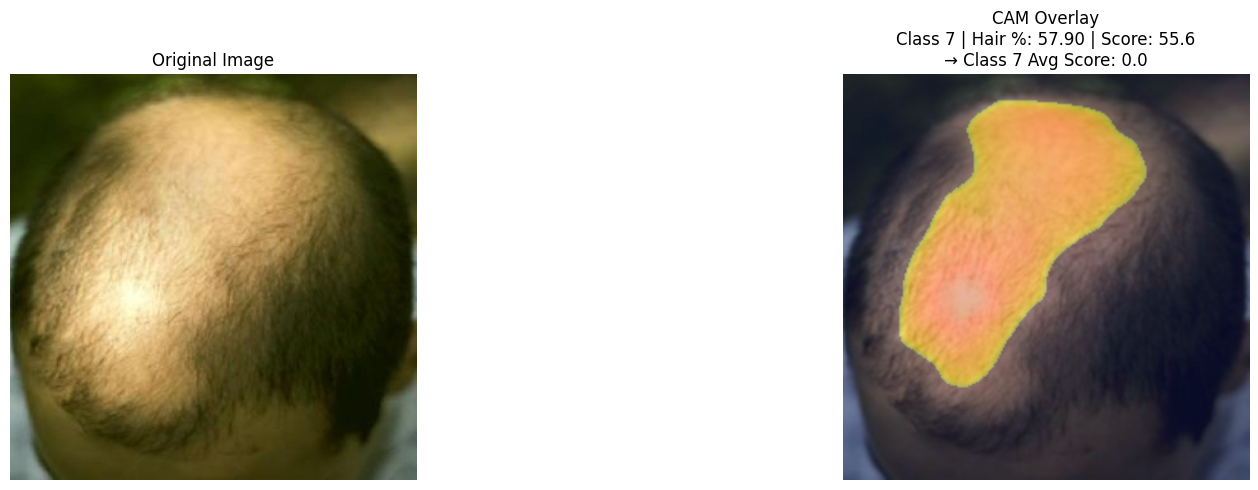

In [16]:
result = predict_and_visualize_all(
    image_path='/content/drive/MyDrive/Colab Notebooks/hair_classification/data/test/109.jpg',
    class_model=dens_model,                      # classification model
    seg_model=seg_model,                         # segmentation model
    target_layer=dens_model.features.relu0,      # CAM에 사용할 layer
    df_density=df_density,                       # class별 밀도 기준 DataFrame
    device='cuda',
    cam_alpha=0.3,
    cam_thresh=0.6
)